<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/heat_equation_deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
#import matplotlib.pyplot as plt

<ipython-input-19-0f694f22a6e1>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  usol[i][j] = heat_eq_exact_solution(x[i], t[j])


Compiling model...
Building feed-forward neural network...
'build' took 0.069794 s

'compile' took 0.591715 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.26e-01, 2.68e-01, 7.21e-01]    [4.13e-01, 2.68e-01, 7.21e-01]    []  
1000      [2.80e-03, 3.06e-03, 2.23e-03]    [1.46e-03, 3.06e-03, 2.23e-03]    []  
2000      [5.37e-04, 2.23e-04, 5.53e-05]    [3.30e-04, 2.23e-04, 5.53e-05]    []  
3000      [1.73e-04, 3.05e-05, 7.26e-06]    [1.09e-04, 3.05e-05, 7.26e-06]    []  
4000      [7.44e-05, 1.36e-05, 2.45e-06]    [3.59e-05, 1.36e-05, 2.45e-06]    []  
5000      [4.92e-05, 9.62e-06, 1.53e-06]    [2.32e-05, 9.62e-06, 1.53e-06]    []  
6000      [3.71e-05, 7.49e-06, 1.12e-06]    [1.74e-05, 7.49e-06, 1.12e-06]    []  
7000      [2.95e-05, 5.86e-06, 9.93e-07]    [1.37e-05, 5.86e-06, 9.93e-07]    []  
8000      [2.40e-05, 4.73e-06, 1.06e-06]    [1.14e-05, 4.73e-06, 1.06e-06]    []  
9000      [2.01e-05, 3.80e-06, 6.

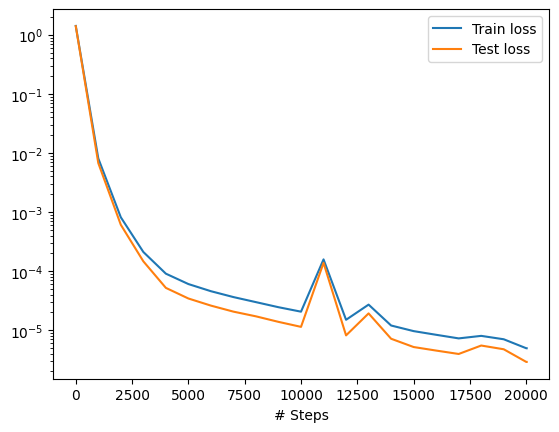

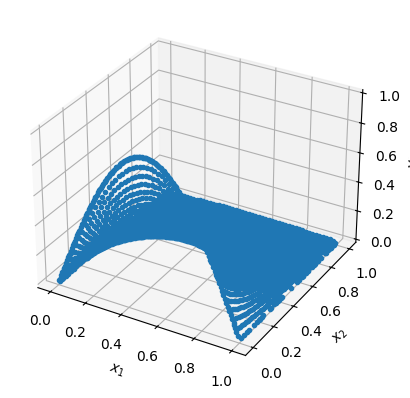

Mean residual: 0.0010798417
L2 relative error: 0.001857842671069986


In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
def heat_eq_exact_solution(x, t):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    return np.exp(-(n**2 * np.pi**2 * a * t) / (L**2)) * np.sin(n * np.pi * x / L)


def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't':
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save solution:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y


# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()


def pde(x, y):
    """Expresses the PDE residual of the heat equation."""
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx


# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(n * np.pi * x[:, 0:1] / L),
    lambda _, on_initial: on_initial,
)

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))